## Census Scraper
In this notebook, we will use the [ONS API](https://developer.ons.gov.uk) to obtain census 2021 data. This has been written for another ONS data exploratory project hosted on [github](https://github.com/cwtravisyip/ONS_Census2021/tree/main).

In [1]:
!curl -O https://raw.githubusercontent.com/cwtravisyip/ONS_Census2021/main/custom_function.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7781  100  7781    0     0  12044      0 --:--:-- --:--:-- --:--:-- 12063


In [ ]:
# import data management packages
import pandas as pd 
import geopandas as gpd
import geojson
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import web data packages
import requests


# import custom defined function from the ONS data exploratory project
from custom_function import *

from api_keys import user_agent_ons

# define header
headers = {"user_agent": user_agent_ons}

# define a function to visualise the 

## 1. Define Geography
For this particular excercise, we can try to look at the census data on the **MSOA** Level. The list of adminstrative areas can be found on the [ONS Open Geography website](https://geoportal.statistics.gov.uk/). We will focus only on England. Note that with the API, **we can only request 2000 instances in one call.** To overcome this issue,  we will have to specify the object id in our query iteratively until the API does not return any new data point. If the api request is not successfuly, the shapefile can also be downloaded onto the local drive through the webpage:

* [Low-Tier Local Authority](https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_December_2011_FEB_EW_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson)
* [Middle Layer Super Output Area](https://geoportal.statistics.gov.uk/search?q=BDY_MSOA%20DEC_2021&sort=Title%7Ctitle%7Casc)
* [Lower Layer Super Output Area](https://geoportal.statistics.gov.uk/search?q=BDY_LSOA%20DEC_2021&sort=Title%7Ctitle%7Casc)

In [ ]:
# MSOA retrieval pipeline 
object_id_start= 0
chunksize = 500
out_crs = 27700
msoa = gpd.GeoDataFrame()
api_base = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Middle_layer_Super_Output_Areas_2021_EW_BFC_V7/FeatureServer/0/"

while object_id_start <= 0:
    print(object_id_start)
    object_ids = ",".join([str(ind) for ind in range(object_id_start,object_id_start + chunksize)])
    object_ids_q = "ObjectIds=" + object_ids
    api_query = f"query?outFields=*&outSR={out_crs}&f=geojson&where=1%3D1&{object_ids_q}"
    api_url = api_base + api_query
    # get the lsoa data
    newd = gpd.read_file(api_url)
    print(len(newd))
    # append to the existing list
    msoa = pd.concat([msoa,newd], ignore_index = True)

    # prepare for next loop
    object_id_start += chunksize

# export the file for easier access
msoa.to_file("./data/MSOA_2021.geojson", driver = "GeoJSON")


In [5]:
# import the files (executable if the file already exists through direct download to local drive)
msoa = gpd.read_file("./data/MSOA_2021")

In [4]:
# inspect the gdf # note that the dataframe should be in epsg:27700
msoa.head()

,MSOA21CD,MSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E02000001,City of London 001,532384,181355,-0.093490,51.5156,283e7adc-faef-4736-9a0b-146cb27c72ec,"POLYGON ((532153.703 182165.155, 532158.250 18..."
1,E02000002,Barking and Dagenham 001,548267,189685,0.138756,51.5865,7b32290e-3b18-45b1-b5d5-bf778f71e3ce,"POLYGON ((548881.304 190819.980, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,548259,188520,0.138149,51.5760,56f43674-2eda-47c0-819a-0cabeb9595f5,"POLYGON ((548958.555 189072.176, 548954.517 18..."
3,E02000004,Barking and Dagenham 003,551004,186412,0.176828,51.5564,fbedb5c5-b92a-475f-899e-1baf1dbae111,"POLYGON ((551550.056 187364.705, 551528.633 18..."
4,E02000005,Barking and Dagenham 004,548733,186824,0.144267,51.5607,f04829fe-a903-4bca-a88a-ace39fdbd3ac,"POLYGON ((549237.051 187627.941, 549241.319 18..."


In [6]:
# sbset to only the english MSOA
msoa_e = msoa[msoa['MSOA21CD'].str.contains("E")]
# return the boundary of england
e_border = msoa_e.geometry.unary_union

In [6]:
msoa_e.describe()

,BNG_E,BNG_N,LONG,LAT
count,6856.000000,6856.000000,6856.000000,6856.000000
mean,453969.743145,275745.554551,-1.216356,52.370738
std,84059.420657,127007.741405,1.216644,1.146381
min,91327.000000,11447.000000,-6.302170,49.923300
25%,393522.250000,175117.250000,-2.098055,51.463100
50%,448350.000000,259002.500000,-1.285650,52.215550
75%,524110.500000,389067.500000,-0.208935,53.395700
max,654401.000000,651742.000000,1.744020,55.759000


## 2. Exploring the ONS API
Using the introduction of the API, we will discet the API system using the dataset code. To return some of the datasets available, there is a built in function in the `custom_function` module. Alternatively, we can search through the ONS page on Census 2021 to find the datasets and their respective id, usually with the preffix "RM" or "TS".

In [4]:
# retrieve the dataset available
dataset_info = get_dataset_info()
dataset_info.head()

## 3. Send API Request
From the census API, there are couple relevant variables for the study of food deserts:

* Car or van availability by household type RM008 (2021:3)
* Population TS001
* Health Status TS037
* Household in Deprivation TS011

To get the API data, we will first need to get the area codes as elements of a list object.


In [25]:
# get the ltla area code 
msoa_code = list(msoa_e['MSOA21CD'])

# subset the list into chunks to loop over
chunksize = 500
n_chunks = np.ceil(len(msoa_code) / chunksize)
area_chunks = np.array_split(msoa_code, n_chunks)

### 3.1 Car or Van Availability (RM008 v2021 ed.3)

In [ ]:
# instantiate an empty pd.DataFrame
rm008 = pd.DataFrame()

# loop over all ltla code
for areas in area_chunks:
    # send census2021_api requests and return as pd.df    
    df = requests_census2021_api(area_code= areas,datasetId="RM008", version = 3, area_type = "msoa", verbose = 0)
    rm008 = pd.concat([rm008, df], ignore_index = True)

3.1.1 Data Diagnosis
Looking at the column names, we can see the data is disaggregated in the following manner:
* Number of cars
    * Household Type

Another thing we may want to manipulate. From a quick inspection, we can see that there are a lot of columns with the "Does not apply" and most of their value are 0. We shall confirm if all the data points on these columns are 0. Note that in comparison to the TS045 dataset, the disaggregation on the number of cars offers less dimension. Namely, the RM008 dataset effectively only divide the population with or without car/vans. In contrast, the TS045 dataset provides the disaggregate in the following dimensions:
* No cars or vans in household
* 1 car or van in household
* 2 cars or vans in household
* 3 or more cars or vans in household
* Does not apply

In [28]:
# inspect the does not apply columns
no_cars_cols = rm008.columns[rm008.columns.str.contains("No cars or vans in household")]
# return the no cars sum 
no_cars = rm008[no_cars_cols].sum(axis = 1).rename("no_cars")
# return total household number
n_household = rm008.drop(columns = ["href","id","label"] ).sum(axis = 1).rename("total")
# return pct
rm008_pct = (no_cars/n_household).rename("rm008")
# merge the pdseries
rm008_output = rm008[["id"]].merge(rm008_pct, left_index = True, right_index = True)

In [10]:
rm008_output["rm008"].describe()

count    6856.000000
mean        0.232114
std         0.146061
min         0.030103
25%         0.119286
50%         0.195650
75%         0.305863
max         0.821348
Name: rm008, dtype: float64

### 3.2 Population (TS001)

In [ ]:
# instantiate an empty pd.DataFrame
ts001 = pd.DataFrame()

# loop over all ltla code
for areas in area_chunks:
    # send census2021_api requests and return as pd.df    
    df = requests_census2021_api(area_code= areas,datasetId="TS001", version = 3, area_type = "msoa", verbose = 0)
    ts001 = pd.concat([ts001, df], ignore_index = True)

In [12]:
# rename the columns for easier indexing
ts001.columns = ["href","id","label","pop","pop_communal_establishment"]
# drop the irrelevant columns
ts001_output = ts001.drop(columns = ["href","label"])
# inspect
ts001_output.describe()

,pop,pop_communal_establishment
count,6856.000000,6856.000000
mean,8095.735123,143.786902
std,1773.814689,444.991175
min,2028.000000,0.000000
25%,6750.750000,17.000000
50%,7853.000000,55.000000
75%,9161.250000,112.000000
max,16246.000000,13449.000000


### 3.3 Health Status (TS037)

In [ ]:
# instantiate an empty pd.DataFrame
ts037 = pd.DataFrame()

# loop over all ltla code
for areas in area_chunks:
    # send census2021_api requests and return as pd.df    
    df = requests_census2021_api(area_code= areas,datasetId="TS037", version = 3, area_type = "msoa", verbose = 0)
    ts037 = pd.concat([ts037, df], ignore_index = True)

In [40]:
# rename the columns for easier access later
ts037 = ts037.rename(columns = {
    "Very good health":"h_vgood",
    "Good health":"h_good",
    "Fair health": "h_fair",
    "Bad health":"h_bad",
    "Very bad health": "h_vbad"})


Return the columns as cumulative percentage for analysis.

In [41]:
ts037.head()

,href,id,label,Does not apply,h_vgood,h_good,h_fair,h_bad,h_vbad
0,,E02000001,City of London 001,0,4937,2726,687,186,47
1,,E02000002,Barking and Dagenham 001,0,4138,2645,1001,358,139
2,,E02000003,Barking and Dagenham 002,0,5938,3889,1242,368,105
3,,E02000004,Barking and Dagenham 003,0,3257,2237,831,262,54
4,,E02000005,Barking and Dagenham 004,0,5837,3572,1185,353,135


In [42]:
# return total 
tot = ts037.sum(axis = 1, numeric_only =True)
# compute the cumulative frequency
cols = ts037.columns
# parse as a list of tuple
cols = [(cols[i],cols[i-1]) for i in np.arange(-1,-5, step = -1)]

for col_i,col_j in cols:
    ts037[col_j] = ts037[col_i] + ts037[col_j]
# return only the relevant cols
ts037_output = ts037.drop(columns = ["href","label","Does not apply"])

In [46]:
# return as percentage of totoal
cols = ts037_output.columns[1:]
for col in cols:
    ts037_output[col] = ts037_output[col] / tot

In [50]:
ts037_output.describe(include = "all")

,id,h_vgood,h_good,h_fair,h_bad,h_vbad
count,6856,6856.0,6856.000000,6856.000000,6856.000000,6856.000000
unique,6856,NaN,NaN,NaN,NaN,NaN
top,E02000001,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.0,0.517058,0.179686,0.052054,0.011843
std,NaN,0.0,0.053265,0.041740,0.018208,0.004734
min,NaN,1.0,0.287718,0.063946,0.010423,0.001516
25%,NaN,1.0,0.484278,0.149376,0.038724,0.008435
50%,NaN,1.0,0.519607,0.176569,0.048904,0.011015
75%,NaN,1.0,0.554550,0.207213,0.062610,0.014361


### 3.4 Household in Deprivation (TS011)

In [ ]:
# instantiate an empty pd.DataFrame
ts011 = pd.DataFrame()

# loop over all ltla code
for areas in area_chunks:
    # send census2021_api requests and return as pd.df    
    df = requests_census2021_api(area_code= areas,datasetId="TS011", version = 3, area_type = "msoa", verbose = 0)
    ts011 = pd.concat([ts011, df], ignore_index = True)

In [58]:
# change the columns names
ts011.columns = ["href","id","label","n/a","imd_0","imd_1","imd_2","imd_3","imd_4"]
# return total 
tot = ts011.sum(axis = 1, numeric_only =True)
# return cumulative total
cols = [(f"imd_{ind}",f"imd_{ind+1}") for ind in [3,2,1,0]]
for col_i,col_j in cols:
    ts011[col_i] = ts011[col_i] + ts011[col_j]
# return as percentage
cols = ts011.columns[4:]
for col in cols:
    ts011[col] = ts011[col]/tot
# return only the relevant cols
ts011_output = ts011.drop(columns = ["href","label","n/a"])

In [59]:
ts011_output.describe(include = "all")

,id,imd_0,imd_1,imd_2,imd_3,imd_4
count,6856,6856.0,6856.000000,6856.000000,6856.000000,6856.000000
unique,6856,NaN,NaN,NaN,NaN,NaN
top,E02000001,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.0,0.516530,0.181399,0.039377,0.002327
std,NaN,0.0,0.088988,0.069755,0.024868,0.002208
min,NaN,1.0,0.270893,0.038512,0.003144,0.000000
25%,NaN,1.0,0.449458,0.126133,0.019601,0.000750
50%,NaN,1.0,0.508603,0.168967,0.032659,0.001657
75%,NaN,1.0,0.579878,0.226816,0.053940,0.003255


## 4. Merge all the output
Merging on all the columns, this returns a dataframe with the following variables:
| Column Name | Data Type | Description |
| ---------     |   --------    | ---------- |
|MSOA21CD | String E[0-9]{8} | MSOA 2021 Code |
|rm008 | Float [0-1] | Percentage of Household without Car | 
| pop | Float [0, $\infty$) | Population | 
| pop_comunual_establishment | Float [0, $\infty$)| Population living in communal establishment| 
| h_vgood | Float [0,$\infty$) | Percentage of population in **very good** health condition or worse |
| h_good | Float [0,$\infty$) | Percentage of population in **good** health condition or worse|
| h_fair | Float [0,$\infty$) | Percentage of population in **fair** health condition or worse |
| h_bad | Float [0,$\infty$) | Percentage of population in **bad** health condition or worse |
| h_vbad | Float [0,$\infty$) | Percentage of population in **very bad** health condition |
| imd_0 | Float [0,$\infty$) | Percentage of household deprived in 0 or more dimension (i.e. total household number) |
| imd_1 | Float [0,$\infty$) | Percentage of household deprived in 1 or more dimensions |
| imd_2 | Float [0,$\infty$) | Percentage of household deprived in 2 or more dimensions |
| imd_3 | Float [0,$\infty$) | Percentage of household deprived in 3 or more dimensions |
| imd_4 | Float [0,$\infty$) | Percentage of household deprived in 4 dimensions  |
| RUC11CD | [A-C][1-3] | Rural Urban Classifcation code (2011) |
| RUC11 | String | Rural Urban Classifcation (2011) |

Removed:
| n_hhold | Float [0,$\infty$) | Number of household |

In [60]:
output = rm008_output.merge(ts001_output, how = "outer", on = 'id')\
                    .merge(ts037_output, how = "outer", on = 'id')\
                    .merge(ts011_output, how = "outer", on = 'id')

In [61]:
output.describe(include = "all")

,id,rm008,pop,pop_communal_establishment,h_vgood,h_good,h_fair,h_bad,h_vbad,imd_0,imd_1,imd_2,imd_3,imd_4
count,6856,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000
unique,6856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,E02000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.232114,8095.735123,143.786902,1.0,0.517058,0.179686,0.052054,0.011843,1.0,0.516530,0.181399,0.039377,0.002327
std,NaN,0.146061,1773.814689,444.991175,0.0,0.053265,0.041740,0.018208,0.004734,0.0,0.088988,0.069755,0.024868,0.002208
min,NaN,0.030103,2028.000000,0.000000,1.0,0.287718,0.063946,0.010423,0.001516,1.0,0.270893,0.038512,0.003144,0.000000
25%,NaN,0.119286,6750.750000,17.000000,1.0,0.484278,0.149376,0.038724,0.008435,1.0,0.449458,0.126133,0.019601,0.000750
50%,NaN,0.195650,7853.000000,55.000000,1.0,0.519607,0.176569,0.048904,0.011015,1.0,0.508603,0.168967,0.032659,0.001657
75%,NaN,0.305863,9161.250000,112.000000,1.0,0.554550,0.207213,0.062610,0.014361,1.0,0.579878,0.226816,0.053940,0.003255


## 5. Compare with Rural Urban Classification
ONS published a [rural urban classification dataset](https://www.ons.gov.uk/methodology/geography/geographicalproducts/ruralurbanclassifications) that maps to the MSOA 2011 version. This dataset is last updated in 2024. Using the [MSOA 2011 to MSOA 2021 look up table](https://geoportal.statistics.gov.uk/datasets/fe04322006bd47bbb5f9a784b05d87da), we can classify MSOA (2021) into rural and urban areas.

In [8]:
# load the classification table
urbs = pd.read_csv("./data/urbs_classification_EW_2011MSOA.csv")
# remove the wales msoa
urbs = urbs[urbs["MSOA11CD"].str.contains("E")]

In [9]:
# load the mapping 
msoa_mapping = pd.read_csv("./data/msoa11_msoa21_mapping.csv")
# remove the welsh msoa
msoa_mapping = msoa_mapping[msoa_mapping["MSOA11CD"].str.contains("E")]

In [10]:
# compare the difference in msoa
set(urbs["MSOA11CD"]).difference(msoa_mapping["MSOA11CD"])

set()

In [11]:
# add the rural urban classification column to the MSOA21CD
urbs_class_2021 = msoa_mapping[["MSOA21CD","MSOA11CD"]].merge(urbs[["MSOA11CD","RUC11CD","RUC11"]], on = "MSOA11CD", how = "left")

In [12]:
# inspect the dataframe
urbs_class_2021.describe(include = "all")

,MSOA21CD,MSOA11CD,RUC11CD,RUC11
count,6876,6876,6876,6876
unique,6856,6791,8,8
top,E02007002,E02000891,C1,Urban city and town
freq,2,3,2976,2976


From the table, we can observe that some of the 2011 MSOA is split into two or more MSOA in 2021. Some of the MSOA21CD covers one or more 2011 MSOA.

In [13]:
urbs_class_2021[urbs_class_2021.duplicated(subset = ["MSOA21CD"], keep= False)]\
        .sort_values("MSOA21CD")

,MSOA21CD,MSOA11CD,RUC11CD,RUC11
6416,E02006974,E02002971,C1,Urban city and town
6417,E02006974,E02002972,C1,Urban city and town
6424,E02006982,E02006183,A1,Urban major conurbation
6425,E02006982,E02006184,A1,Urban major conurbation
6445,E02007002,E02001599,B1,Urban minor conurbation
6446,E02007002,E02001601,B1,Urban minor conurbation
6447,E02007003,E02005243,C1,Urban city and town
6448,E02007003,E02005244,C1,Urban city and town
6687,E02007022,E02004347,D1,Rural town and fringe
6686,E02007022,E02004346,E2,Rural village and dispersed in a sparse setting


For the most part, the duplicating MSOA were given the same classification. We will randomly remove these duplicaes.

In [14]:
# drop duplicate msoa21cd
urbs_class_2021 = urbs_class_2021.drop_duplicates(subset = ["MSOA21CD"], keep = "first")

In [ ]:
# merge the the outouput file
output = output.merge(urbs_class_2021.drop(columns = "MSOA11CD"),
             left_on = "id", right_on = "MSOA21CD",
             how = "left")\
                .drop(columns = 'id')
# reorder the columns and drop irrelevant columns
output = output[['MSOA21CD','rm008', 'pop', 'pop_communal_establishment', 'h_vgood', 'h_good',
       'h_fair', 'h_bad', 'h_vbad', 'imd_0', 'imd_1', 'imd_2', 'imd_3',
       'imd_4', 'RUC11CD', 'RUC11']]

In [79]:
output.describe(include = "all")

,MSOA21CD,rm008,pop,pop_communal_establishment,h_vgood,h_good,h_fair,h_bad,h_vbad,imd_0,imd_1,imd_2,imd_3,imd_4,RUC11CD,RUC11
count,6856,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000,6856.0,6856.000000,6856.000000,6856.000000,6856.000000,6856,6856
unique,6856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
top,E02000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1,Urban city and town
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2966,2966
mean,NaN,0.232114,8095.735123,143.786902,1.0,0.517058,0.179686,0.052054,0.011843,1.0,0.516530,0.181399,0.039377,0.002327,NaN,NaN
std,NaN,0.146061,1773.814689,444.991175,0.0,0.053265,0.041740,0.018208,0.004734,0.0,0.088988,0.069755,0.024868,0.002208,NaN,NaN
min,NaN,0.030103,2028.000000,0.000000,1.0,0.287718,0.063946,0.010423,0.001516,1.0,0.270893,0.038512,0.003144,0.000000,NaN,NaN
25%,NaN,0.119286,6750.750000,17.000000,1.0,0.484278,0.149376,0.038724,0.008435,1.0,0.449458,0.126133,0.019601,0.000750,NaN,NaN
50%,NaN,0.195650,7853.000000,55.000000,1.0,0.519607,0.176569,0.048904,0.011015,1.0,0.508603,0.168967,0.032659,0.001657,NaN,NaN
75%,NaN,0.305863,9161.250000,112.000000,1.0,0.554550,0.207213,0.062610,0.014361,1.0,0.579878,0.226816,0.053940,0.003255,NaN,NaN


## 6. Visualisation


### 6.1 Rural Urban Classification

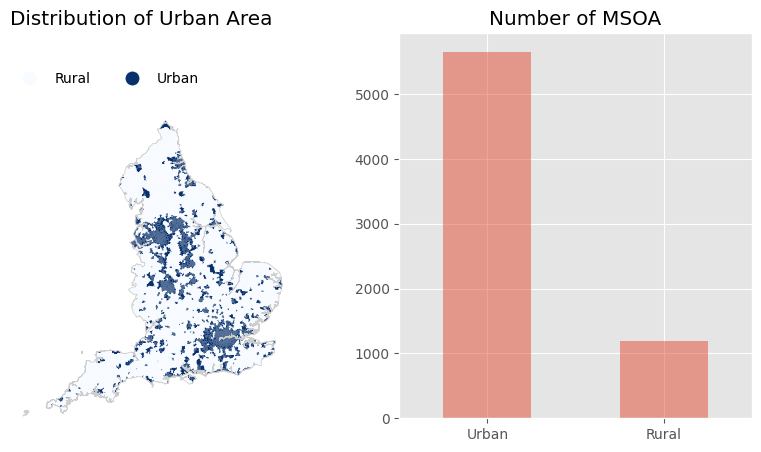

In [80]:
# return the temporary dataframe
temp = msoa_e.merge(output, on = "MSOA21CD")
# return binary variable of urban
temp["urban"] = temp["RUC11"].str.contains("Urban").map({True:"Urban",False:"Rural"})
var = "urban" # column name
title = "Distribution of Urban Area"

# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
temp.plot(column = var, cmap='Blues',
        #   missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend = True,
          legend_kwds = {'loc':(0,0.85), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title(title, loc = "left")
ax[0].set_axis_off()

# plot frequency density
ax[1].set_title("Number of MSOA")
temp["urban"].value_counts().plot(kind = "bar", ax= ax[1], alpha = 0.5)
ax[1].set_xlabel("")
ax[1].set_xticklabels(temp["urban"].value_counts().index,rotation = 0)

plt.savefig("./img/urbs_class.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [81]:
temp["urban"].value_counts(normalize = True)

urban
Urban    0.825263
Rural    0.174737
Name: proportion, dtype: float64

### 6.2 Car Ownership

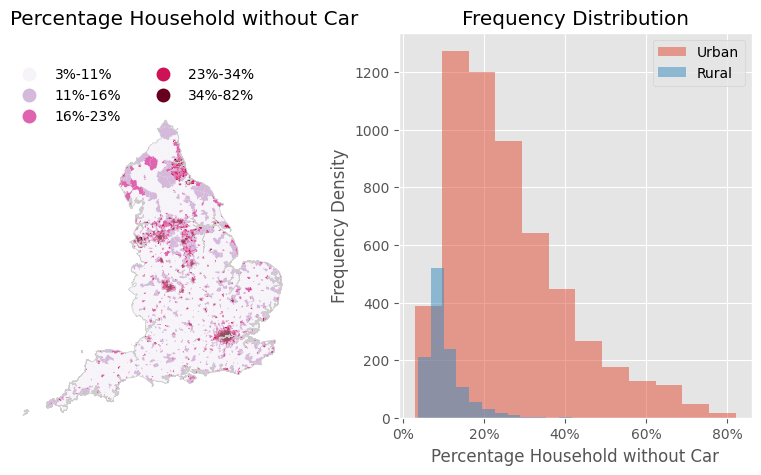

In [94]:
# return the temporary dataframe
temp = msoa_e.merge(output, on = "MSOA21CD")
var = "rm008" # column name
title = "Percentage Household without Car"

# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
temp.plot(column = var, cmap='PuRd',scheme='quantiles',
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend = True,
          legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title(title, loc = "left")
ax[0].set_axis_off()
# update legend lable
leg = ax[0].get_legend()
for text in leg.get_texts():
    # get the upper and lower bound
    limits = [float(lim) for lim in  text.get_text().split(",")]
    # paraw as lavle
    label = f"{limits[0]:.0%}-{limits[1]:.0%}"
    text.set_text(label)


# plot frequency density
ax[1].set_title("Frequency Distribution")
# plot urban
temp[temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Urban")
temp[~temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Rural")
ax[1].set_xlabel(title)
ax[1].xaxis.set_major_formatter('{x:.0%}')
ax[1].set_ylabel("Frequency Density")
ax[1].legend()

plt.savefig("./img/pct_household_wm_car.png", dpi = 300, bbox_inches = "tight")
plt.show()

### 6.3 Population

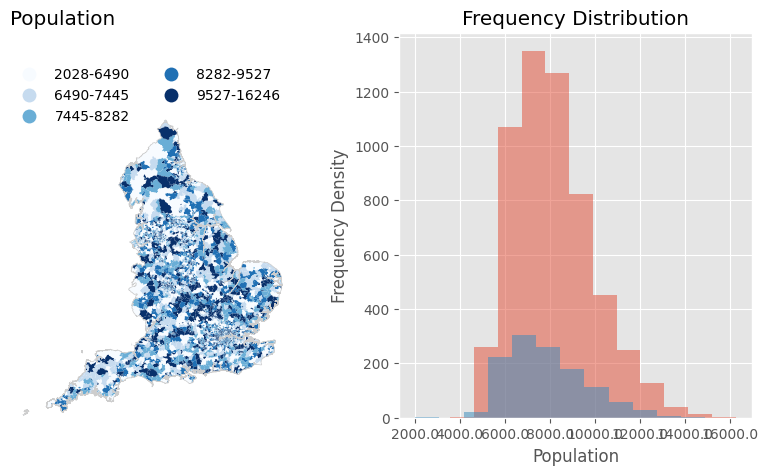

In [98]:
# return the temporary dataframe
temp = msoa_e.merge(output, on = "MSOA21CD")
var = "pop" # column name
title = "Population"

# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
temp.plot(column = var, cmap='Blues',scheme='quantiles',
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend = True,
          legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title(title, loc = "left")
ax[0].set_axis_off()
# update legend lable
leg = ax[0].get_legend()
for text in leg.get_texts():
    # get the upper and lower bound
    limits = [float(lim) for lim in  text.get_text().split(",")]
    # paraw as lavle
    label = f"{limits[0]:.0f}-{limits[1]:.0f}"
    text.set_text(label)


# plot frequency density
ax[1].set_title("Frequency Distribution")
# plot urban
temp[temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Urban")
temp[~temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Rural")
ax[1].set_xlabel(f"{title}")
ax[1].xaxis.set_major_formatter('{x}')
ax[1].set_ylabel("Frequency Density")


plt.savefig("./img/population.png", dpi = 300, bbox_inches = "tight")
plt.show()

### 6.4 Health
We will return the percentage of household reported with good health.

In [99]:
# return the temporary dataframe
temp = msoa_e.merge(output, on = "MSOA21CD")

temp["health"] = temp[["h_vbad","h_bad"]].sum(axis = 1) /\
                    temp[["h_vgood","h_good","h_fair","h_bad","h_bad"]].sum(axis = 1) * 100

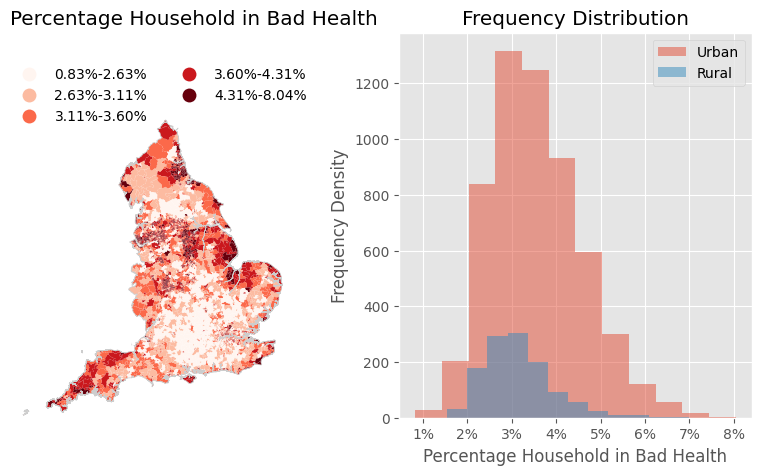

In [101]:
# return the temporary dataframe
var = "health" # column name
title = "Percentage Household in Bad Health"

# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
temp.plot(column = var, cmap='Reds',scheme='quantiles',
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend = True,
          legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title(title, loc = "left")
ax[0].set_axis_off()
# update legend lable
leg = ax[0].get_legend()
for text in leg.get_texts():
    # print(text.get_text())
    # get the upper and lower bound
    limits = [float(lim) for lim in  text.get_text().split(",")]
    # paraw as lavle
    label = f"{limits[0]:.2f}%-{limits[1]:.2f}%"
    text.set_text(label)


# plot frequency density
ax[1].set_title("Frequency Distribution")
# plot urban
temp[temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Urban")
temp[~temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Rural")
ax[1].set_xlabel(title)
ax[1].xaxis.set_major_formatter('{x:.0f}%')
ax[1].set_ylabel("Frequency Density")
ax[1].legend()

plt.savefig("./img/health.png", dpi = 300, bbox_inches = "tight")
plt.show()

### 6.5 Household Deprivation

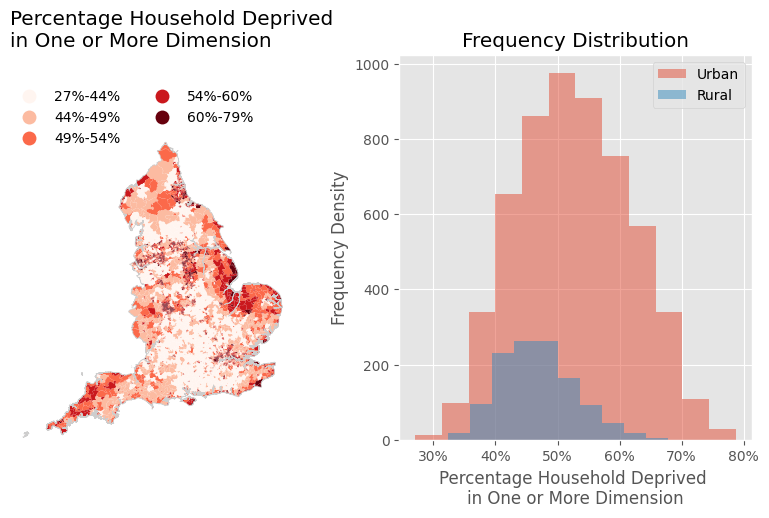

In [104]:
# return the temporary dataframe
var = "imd_1" # column name
title = "Percentage Household Deprived \nin One or More Dimension"

# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
temp.plot(column = var, cmap='Reds',scheme='quantiles',
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend = True,
          legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title(title, loc = "left")
ax[0].set_axis_off()
# update legend lable
leg = ax[0].get_legend()
for text in leg.get_texts():
    # print(text.get_text())
    # get the upper and lower bound
    limits = [float(lim) for lim in  text.get_text().split(",")]
    # paraw as lavle
    label = f"{limits[0]:.0%}-{limits[1]:.0%}"
    text.set_text(label)


# plot frequency density
ax[1].set_title("Frequency Distribution")
# plot urban
temp[temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Urban")
temp[~temp["RUC11"].str.contains("Urban")][var].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Rural")
ax[1].set_xlabel(title)
ax[1].xaxis.set_major_formatter('{x:.0%}')
ax[1].set_ylabel("Frequency Density")
ax[1].legend()

plt.savefig("./img/h_dpr.png", dpi = 300, bbox_inches = "tight")
plt.show()

## 7. Export the file

In [82]:
output.to_csv("./data/ons_census_2021.csv", index = False)